In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector

# from qiskit.primitives import Sampler
from qiskit_aer.primitives import Sampler
# from qiskit_aer import Aer

from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import AmplitudeEstimation
from qiskit_algorithms import IterativeAmplitudeEstimation

import os
import math
import random
import numpy as np
import pandas as pd
# from scipy.stats import weibull_min
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Define the file paths and names
sample_path = ""
sample_filenames_ff = [
    # "values_b_0.25_0.75_f_4_6_m-1_3_2_21.csv"      # 2^21 sample values
    "values_b_0.25_0.75_f_4_6_m-1_3_2_24.csv"      # 2^24 sample values
]

# Initialize empty lists to store dataframes
df_fracture_flow = []

# Read CSV files and append dataframes to lists
for filename in sample_filenames_ff:
    df_fracture_flow.append(pd.read_csv(sample_path + filename, delimiter=' '))

In [3]:
# ff_samples = df_fracture_flow[0].values.reshape(-1,1).flatten()
ff_samples = df_fracture_flow[0]['ff_values'].values.reshape(-1,1).flatten()

# ff_samples = 10**3 * (ff_samples - np.mean(ff_samples)) + 0.4952211418615139    # 1/2
# ff_samples = 10**2.5 * (ff_samples - np.mean(ff_samples)) + np.mean(ff_samples)   # 10**1 10**2 10**3

min_val_gt = np.min(ff_samples)
max_val_gt = np.max(ff_samples)
dif_max_min_val_gt = max_val_gt - min_val_gt

ff_samples = (ff_samples - min_val_gt) / dif_max_min_val_gt
# normalized_samples = (ff_samples - min_val_gt) / dif_max_min_val_gt

ff_mean = np.mean(ff_samples)
ff_var  = np.var(ff_samples)
# ff_norm_mean = np.mean(normalized_samples)
# ff_norm_var  = np.var(normalized_samples)

# 0.40879763          0.05785958          (2^21 =   2,097,152)
# 0.40861735399302224 0.0574683234476481  (2^24 =  16,777,216)
# 0.4085276115369493  0.05727359714538968 (2^27 = 134,217,728)

gt_mean = 0.4085276115369493
gt_var  = 0.05727359714538968

print(np.round(ff_mean,8), np.round(ff_var,8))
print(np.round(np.abs(gt_mean-ff_mean),8), np.round(np.abs(gt_var-ff_var),8))
# print(ff_samples, len(ff_samples), ff_samples.shape, type(ff_samples))
# print(np.round(ff_mean,8), np.round(ff_var,8), np.round(ff_norm_mean,8), np.round(ff_norm_var,8))

0.40861735 0.05746832
8.974e-05 0.00019472


In [4]:
# Function to calculate the sample average and the error
def sample_error(sample_mean, distribution_mean):
    error = np.abs(sample_mean - distribution_mean)
    return error

# Function to calculate the sample average and the error
def sample_relative_error(sample_mean, distribution_mean):
    if distribution_mean != 0:
        error = np.abs( sample_mean / distribution_mean - 1 )
    else:
        error = -1
    return error

# Function to generate tuple of (value,count) pairs
def unique_values_with_counts(arr):
    # Dictionary to count occurrences of each value
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Generate the result array with values and their counts
    result = [(value, count) for value, count in counts.items()]
    
    return result

In [5]:
# Function to generate psi basis state index tuples of (value,count) pairs
#   digits_precision_circuit - circuit precision base 2
def psi_basis_state_sample_index_counts(digits_precision_circuit=4, scaling_samples=20):

    # ff_samples test_ff test_rvw_ff
    data_samples = ff_samples
    
    dist_samples = np.array(random.sample(list(data_samples), 2**(scaling_samples)))
    # dist_samples = ff_samples[0:2**scaling_samples]
    dist_sample_mean = np.mean(dist_samples)

    print(len(dist_samples))

    # Normalize samples between 0 and 1
    
    # normalized dist mean ground truth (all samples)

    dist_mean = np.mean(data_samples)

    min_val_gt = np.min(data_samples)
    max_val_gt = np.max(data_samples)
    dif_max_min_val_gt = max_val_gt - min_val_gt

    dist_mean_normalized = (dist_mean - min_val_gt) / dif_max_min_val_gt

    # min_val = np.min(dist_samples)
    # max_val = np.max(dist_samples)
    # dif_max_min_val = max_val - min_val

    normalized_samples = (dist_samples - min_val_gt) / dif_max_min_val_gt
    # normalized_samples = (dist_samples - min_val) / dif_max_min_val
    
    # print(min_val)
    # print(max_val)
    # print(dif_max_min_val)
    # print(type(normalized_samples))
    # print(normalized_samples)

    dist_sample_mean_normalized = (dist_sample_mean - min_val_gt) / dif_max_min_val_gt
    # dist_sample_mean_normalized = (dist_sample_mean - min_val) / dif_max_min_val
    
    # compute index discrete distribution
    normalized_samples_int_dec_rnd = np.array([int(np.round(sample_value)) if np.round(sample_value) < 2**digits_precision_circuit else 2**digits_precision_circuit-1 for sample_value in normalized_samples * 2**digits_precision_circuit])
    
    # tally up sample values and counts
    index_circuit_unique_counts = unique_values_with_counts(normalized_samples_int_dec_rnd)

    # print(dist_mean, dist_sample_mean, dist_mean_normalized, dist_sample_mean_normalized)
    # print(len(index_circuit_unique_counts))
    # print(index_circuit_unique_counts)

    print()

    return index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized

In [6]:
# Function to generate psi basis state index tuples of (value,count) pairs
#   index_circuit_unique_counts - psi basis state counts
#   digits_precision_circuit - circuit precision base 2
def psi_generate_qc(index_circuit_unique_counts, digits_precision_circuit=4, scaling_samples = 20):

    # number of bins for distribution
    estimate_samples_inv = 2**(-scaling_samples)
    
    # Create the full state vector of size dist_bins and initialize to zero
    state_vector = np.zeros(2**(digits_precision_circuit+1), dtype=complex)
    
    print(len(state_vector))
    
    # sample_value_index - psi basis state index
    # sample_value_phi - assigned to corresponding index (state psi) multiplied by probability
    
    # Assign the given amplitudes to the corresponding basis state indices
    psi_mean_normalized = 0
    for sample_value_index, count in index_circuit_unique_counts:
        sample_value_phi = sample_value_index * 2**(-digits_precision_circuit)
        state_vector[sample_value_index*2 + 1] = np.sqrt(sample_value_phi * count * estimate_samples_inv)
        state_vector[sample_value_index*2 + 0] = np.sqrt((1 - sample_value_phi) * count * estimate_samples_inv)
        psi_mean_normalized += sample_value_phi * count * estimate_samples_inv

    print(psi_mean_normalized)

    print()
    
    # Normalize the state vector
    state_vector /= np.linalg.norm(state_vector)
    
    # Create a quantum circuit with n+1 qubits
    qc = QuantumCircuit(digits_precision_circuit+1)
    
    # Use StatePreparation to initialize the state
    state_prep = StatePreparation(state_vector)
    qc.append(state_prep, list(range(digits_precision_circuit+1)))
    
    # # Draw the circuit
    # qc.draw(output='mpl', style='clifford')

    return qc

In [ ]:
%%time
digits_precision_circuit_MAX   = 12    # base 2 precision = ceil(log2(10**digits_precision_base_10))
digits_precision_circuit_FIXED = 6     # fixed size state psi
digits_precision_OUT           = 8     # base 10 precision output
SHOTS                          = 2**10 # number of measurements


qae_problem_list = []
qae_ae_list = []
qae_dist_mean_list = []
qae_sample_mean_list = []
qae_sample_error_list = []
qae_sample_relative_error_list = []
qae_sample_scaling_list = []

# Iterate over circuit digits of precision
for digits_precision_circuit in range(1, digits_precision_circuit_MAX+1):

    dpc = digits_precision_circuit_FIXED
    # dpc = math.ceil( digits_precision_circuit_FIXED * digits_precision_circuit / digits_precision_circuit_MAX )

    ss = int(math.log2(len(ff_samples)))
    # ss = 2*digits_precision_circuit

    index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized = psi_basis_state_sample_index_counts(digits_precision_circuit=dpc, scaling_samples=ss)

    qc = psi_generate_qc(index_circuit_unique_counts, digits_precision_circuit=dpc, scaling_samples=ss)

    problem = EstimationProblem(
        state_preparation=qc,  # A operator
        objective_qubits=[0]   # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    neq = digits_precision_circuit
    
    # Initialize the Sampler with options for fastest simulation
    sampler = Sampler(
        # backend_options={},
        run_options={"shots": SHOTS, "seed": 42},  # number of shots for simulation, random seed
        # skip_transpilation=True  # Skip transpilation for speed
    )

    # Initialize the Sampler with options for fastest simulation
    # sampler = Sampler(
    #     options={
    #         "shots": 1,  # specify number of measurement (default=2^10)
    #         "seed": 42,  # fixed random seed for reproducibility
    #     }
    # )
        
    # sampler = Sampler()
    ae = AmplitudeEstimation(
        num_eval_qubits=neq,  # the number of evaluation qubits specifies circuit width and accuracy
        sampler=sampler
    )

    ae_result = ae.estimate(problem)
    
    est_qoi_normalized = ae_result.estimation
    num_queries = int(ae_result.num_oracle_queries / SHOTS)
    # num_queries = ae_result.num_oracle_queries

    # dist_mean_normalized = 0.4085276115369493 # 0.4085276115369493 0.05727359714538968 2_27 (2^27 = 134,217,728)
    
    gt_mean = 0.4085276115369493
    gt_mean_err  = np.abs(gt_mean - dist_mean_normalized)
    print(dist_mean_normalized)
    print(gt_mean, gt_mean_err)
    print()

    dist_mean_normalized_out = float(np.round(dist_mean_normalized, digits_precision_OUT))
    # dist_mean_normalized_out = math.trunc(dist_mean_normalized * 10**digits_precision_OUT) / 10**digits_precision_OUT
    sample_mean_out = float(np.round(est_qoi_normalized, digits_precision_OUT))
    sample_error_out = float(np.round(sample_error(est_qoi_normalized, dist_mean_normalized) + gt_mean_err, digits_precision_OUT))
    # sample_error_out = float(np.max([np.round(sample_error(est_qoi_normalized, dist_mean_normalized), digits_precision_OUT), 10**(-digits_precision_OUT)]))
    sample_relative_error_out = float(np.round(sample_relative_error(est_qoi_normalized, dist_mean_normalized), digits_precision_OUT))

    qae_problem_list.append(problem)
    qae_ae_list.append(ae)
    qae_dist_mean_list.append(dist_mean_normalized_out)
    qae_sample_mean_list.append(sample_mean_out)
    qae_sample_error_list.append(sample_error_out)
    qae_sample_relative_error_list.append(sample_relative_error_out)
    qae_sample_scaling_list.append(num_queries+1) # total applications of A


print(qae_dist_mean_list)
print(qae_sample_mean_list)
print(qae_sample_error_list)
print(qae_sample_relative_error_list)
print(qae_sample_scaling_list)

print()


# problem = problem_list[0]
# ae = ae_list[0]

# ae_circuit = ae.construct_circuit(problem)
# ae_circuit.decompose().draw(
#     "mpl", style="clifford"
# )  # decompose 1 level: exposes the Phase estimation circuit!


# print(dist_mean, dist_sample_mean, dist_mean_normalized, dist_sample_mean_normalized)



16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041

0.40861735399302224
0.4085276115369493 8.974245607296094e-05

16777216

128
0.4086155379191041



In [67]:
# qae_dist_mean_list_back      = qae_dist_mean_list.copy()
# qae_sample_mean_list_back    = qae_sample_mean_list.copy()
# qae_sample_error_list_back   = qae_sample_error_list.copy()
# qae_sample_scaling_list_back = qae_sample_scaling_list.copy()

print(qae_dist_mean_list_back)
print(qae_sample_mean_list_back)
print(qae_sample_error_list_back)
print(qae_sample_scaling_list_back)

[0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735]
[0.0, 0.5, 0.5, 0.5, 0.4024548, 0.4024548, 0.4024548, 0.4024548, 0.4084801, 0.4084801, 0.4084801, 0.4084801]
[0.4087071, 0.09147239, 0.09147239, 0.09147239, 0.0062523, 0.0062523, 0.0062523, 0.0062523, 0.000227, 0.000227, 0.000227, 0.000227]
[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


In [7]:
# qae_dist_mean_list = [0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735, 0.40861735]
# qae_sample_mean_list = [0.0, 0.5, 0.5, 0.5, 0.4024548, 0.4024548, 0.4024548, 0.4024548, 0.4084801, 0.4084801, 0.4084801, 0.4084801]
# qae_sample_error_list = [0.4087071, 0.09147239, 0.09147239, 0.09147239, 0.0062523, 0.0062523, 0.0062523, 0.0062523, 0.000227, 0.000227, 0.000227, 0.000227]
# qae_sample_scaling_list = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

In [59]:
print(ae_result)

{   'circuit_results': {'0100011100': 1},
    'confidence_interval': (   np.float64(0.4064024507424323),
                               np.float64(0.4105593855572589)),
    'confidence_interval_processed': (   np.float64(0.4064024507424323),
                                         np.float64(0.4105593855572589)),
    'estimation': np.float64(0.4084801),
    'estimation_processed': np.float64(0.4084801),
    'max_probability': 1.0,
    'measurements': {226: 1.0},
    'mle': np.float64(0.4084801),
    'mle_processed': np.float64(0.4084801),
    'num_evaluation_qubits': 10,
    'num_oracle_queries': 1023,
    'samples': {np.float64(0.4084801): 1.0},
    'samples_processed': {np.float64(0.4084801): 1.0},
    'shots': 1}


In [60]:
test = ae_result.circuit_results
test2 = ae_result.measurements
test3 = ae_result.samples
test4 = ae_result.samples_processed
print(len(test),len(test2),len(test3),len(test4))

1 1 1 1


In [61]:
test4

{np.float64(0.4084801): 1.0}

In [62]:
total_sum = sum(test.values())
print(total_sum)

1


In [11]:
%%time
sample_scaling_MAX             = 12   # distribution sample size base 2
digits_precision_OUT           = 8    # base 10 precision output

cmc_dist_mean_list = []
cmc_sample_mean_list = []
cmc_sample_error_list = []
cmc_sample_relative_error_list = []
cmc_sample_scaling_list = []
for sample_scaling in range(1, sample_scaling_MAX+1):

    # sample dist for comparision sample scaling cmc vs qae

    # Generating data for the dist
    gt_ff = ff_samples # ff_samples test_ff test_rvw_ff
    # mean for fracture flow dist
    gt_ff_mean = np.mean(gt_ff)
    # mean for fracture flow dist samples
    random.seed(42 + 6) # random seed 3 5 23 26 30 / 6 
    sample_ff = np.array(random.sample(list(gt_ff), 2**(sample_scaling)))
    sample_ff_mean = np.mean(sample_ff)

    
    # INSTEAD - 5 or 10 runs then take avg of estimation error (NOT S_n's)
    
    # # take the sample average over 10 iterations
    # sample_ff_mean_list = []
    # for i in range(0, 10): 
    #     # mean for fracture flow dist samples
    #     # np.random.seed(4)
    #     sample_ff = np.array(random.sample(list(gt_ff), 2**(sample_scaling)))
    #     # sample_ff = np.array(random.sample(list(gt_ff), 2**(2*sample_scaling)))
    #     sample_ff_mean_list.append(float(np.mean(sample_ff)))

    # sample_ff_mean = np.mean(sample_ff_mean_list)

    # print(len(gt_ff))
    # print(len(sample_ff))

    gt_ff_mean = 0.4085276115369493 # 0.4085276115369493 0.05727359714538968 2_27 (2^27 = 134,217,728)

    gt_ff_mean_out = float(np.round(gt_ff_mean, digits_precision_OUT))
    sample_ff_mean_out = float(np.round(sample_ff_mean, digits_precision_OUT))
    sample_error_out = float(np.round(sample_error(sample_ff_mean, gt_ff_mean), digits_precision_OUT))
    # sample_error_out = float(np.max([np.round(sample_error(sample_ff_mean, gt_ff_mean), digits_precision_OUT), 10**(-digits_precision_OUT)]))
    sample_relative_error_out = float(np.round(sample_relative_error(sample_ff_mean, gt_ff_mean), digits_precision_OUT))

    cmc_dist_mean_list.append(gt_ff_mean_out)
    cmc_sample_mean_list.append(sample_ff_mean_out)
    cmc_sample_error_list.append(sample_error_out)
    cmc_sample_relative_error_list.append(sample_relative_error_out)
    cmc_sample_scaling_list.append(2**sample_scaling)


print(cmc_dist_mean_list)
print(cmc_sample_mean_list)
print(cmc_sample_error_list)
print(cmc_sample_relative_error_list)
print(cmc_sample_scaling_list)

print()



[0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761, 0.40852761]
[0.64062429, 0.47029009, 0.34047756, 0.44206655, 0.45147088, 0.47654753, 0.44087776, 0.42890441, 0.3932026, 0.40362062, 0.39595154, 0.4006073]
[0.23209668, 0.06176248, 0.06805005, 0.03353894, 0.04294327, 0.06801992, 0.03235015, 0.02037679, 0.01532501, 0.00490699, 0.01257607, 0.00792031]
[0.56812972, 0.15118312, 0.16657393, 0.08209712, 0.10511717, 0.16650018, 0.07918719, 0.04987862, 0.03751278, 0.0120114, 0.03078389, 0.01938745]
[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

CPU times: user 4.59 s, sys: 764 ms, total: 5.36 s
Wall time: 5.36 s


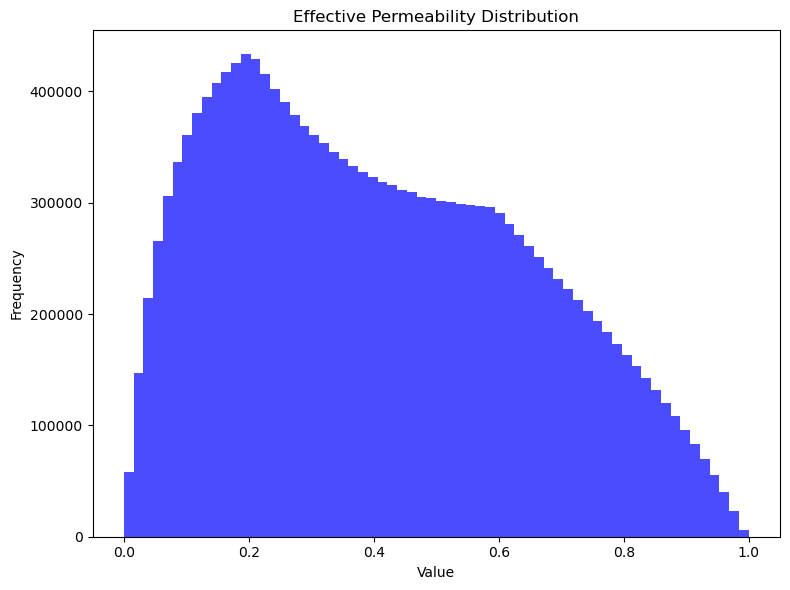

In [8]:
# data for the fracture flow distributions
data_FF = ff_samples
# data_FF = test_ff
# data_FF = test_rvw_ff

# Plotting the histograms of the distributions
plt.figure(figsize=(8, 6))

plt.hist(data_FF, bins=2**6, color='blue', alpha=0.7)
plt.title('Effective Permeability Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
# plt.savefig('dist_fracture_flow_asym.png', dpi=300)  # Save as a high-resolution image
plt.show()

In [9]:
# Define the function we want to fit: y = m * 1/x
def curve_func_ae(x, m):
    return m / x
    
# Define the function we want to fit: y = m * 1/sqrt(x)
def curve_func_mc(x, m):
    return m / np.sqrt(x)

# use a power law relationship: y = alpha * x^beta
def power_law(x, alpha, beta):
    return alpha * np.power(x, beta)

def linear_law(x, m, b):
    return m * x + b

In [12]:
# Convert to numpy arrays
x_data = np.array(qae_sample_scaling_list)
y_data = np.array(qae_sample_error_list) #, dtype="float64"

# # Perform the curve fit
# params, covariance = curve_fit(curve_func_ae, x_data, y_data)
# # Extract the fitting parameters
# m_fit_ae = params
# # Generate values for the fitted line
# y_fit_ae = curve_func_ae(x_data, m_fit_ae)

# Perform the curve fit
params, covariance = curve_fit(linear_law, np.log2(x_data), np.log2(y_data))
# params, covariance = curve_fit(linear_law, np.log2(x_data), np.log10(y_data))
# params, covariance = curve_fit(power_law, x_data, y_data)
# Extract the fitting parameters
m_fit_ae, b_fit_ae = params
# alpha_fit_ae, beta_fit_ae = params
# Generate values for the fitted line
# Convert parameters back: y = alpha x^beta   <--->   log2(y) = log2(alpha) + beta * log2(x)
# CoB log10(y) = log2(y) / log2(10)             -->   log10(y) = 1/log2(10) (log2(alpha) + beta * log2(x))
# linear fit                                    -->   log2_y  = m log2_x + b -> m = beta, b = log2(alpha)
# linear fit                                    -->   log10_y = m log2_x + b -> m = beta/log2(10), b = log2(alpha)/log2(10)
y_fit_ae = power_law(x_data, 2**b_fit_ae, m_fit_ae)
# y_fit_ae = power_law(x_data, 10**b_fit_ae, m_fit_ae*np.log2(10))
# y_fit_ae = power_law(x_data, alpha_fit_ae, beta_fit_ae)

# print(params, covariance)

# print(x_data)
# print(y_data)
# print(y_fit_ae)

# Convert to numpy arrays
x_data = np.array(cmc_sample_scaling_list)
y_data = np.array(cmc_sample_error_list)

# # Perform the curve fit
# params, covariance = curve_fit(curve_func_mc, x_data, y_data)
# # Extract the fitting parameters
# m_fit_mc = params
# # Generate values for the fitted line
# y_fit_mc = curve_func_mc(x_data, m_fit_mc)

# Perform the curve fit
params, covariance = curve_fit(linear_law, np.log2(x_data), np.log2(y_data))
# params, covariance = curve_fit(power_law, x_data, y_data)
# Extract the fitting parameters
m_fit_mc, b_fit_mc = params
# alpha_fit_mc, beta_fit_mc = params
# Generate values for the fitted line
y_fit_mc = power_law(x_data, 2**b_fit_mc, m_fit_mc)
# y_fit_mc = power_law(x_data, alpha_fit_mc, beta_fit_mc)

# print(x_data)
# print(y_data)
# print(y_fit_mc)

# Print the fitted parameters
# print(f"Fitted parameters: m_ae = {m_fit_ae}")
# print(f"Fitted parameters: m_mc = {m_fit_mc}")

print(f"Fitted parameters: alpha_fit_ae = {2**b_fit_ae}, beta_fit_ae = {m_fit_ae}")
# print(f"Fitted parameters: alpha_fit_ae = {10**b_fit_ae}, beta_fit_ae = {m_fit_ae*np.log2(10)}")
# print(f"Fitted parameters: alpha_fit_ae = {alpha_fit_ae}, beta_fit_ae = {beta_fit_ae}")
print(f"Fitted parameters: alpha_fit_mc = {2**b_fit_mc}, beta_fit_ae = {m_fit_mc}")
# print(f"Fitted parameters: alpha_fit_mc = {alpha_fit_mc}, beta_fit_mc = {beta_fit_mc}")

Fitted parameters: alpha_fit_ae = 0.6544807249937271, beta_fit_ae = -1.0513995010539376
Fitted parameters: alpha_fit_mc = 0.17008838069852295, beta_fit_ae = -0.3873145828061242


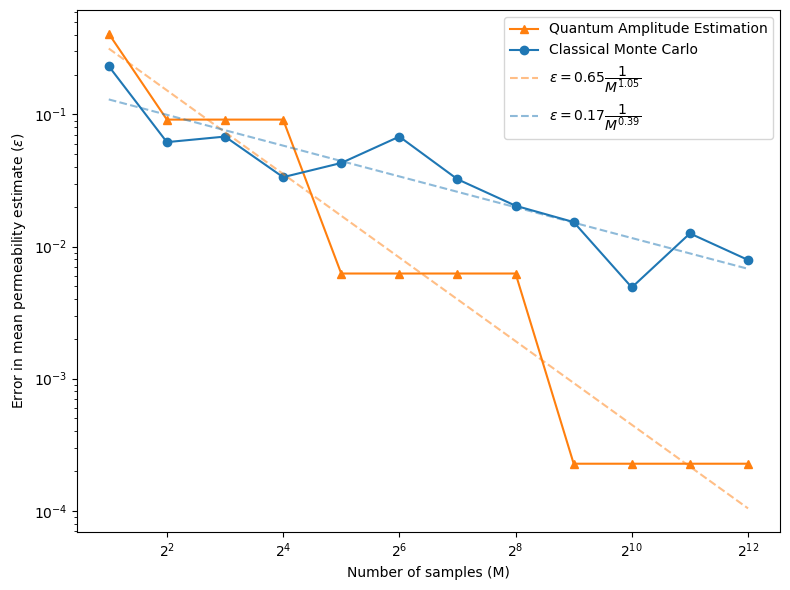

In [20]:
## plot error vs number of samples qae vs cmc / fracture flow distribution

# y_ae_error_vs_ss = 1 * (2*np.pi*np.sqrt(gt_mean*(1-gt_mean)) * 1/np.asarray(qae_sample_scaling_list) + (np.pi / np.asarray(qae_sample_scaling_list))**2)

# y_ae_error_vs_ss = 4/20 * (2*np.pi*np.sqrt(gt_mean*(1-gt_mean)) * 1/np.asarray(qae_sample_scaling_list) + (np.pi / np.asarray(qae_sample_scaling_list))**2)
# y_mc_error_vs_ss = 5/20 * 1/np.sqrt(np.asarray(cmc_sample_scaling_list))      # 5/20 samples = 1/epsilon^2 => error = 1/sqrt(samples)

# y_ae_error_vs_ss = 9/20 * 1/np.asarray(qae_sample_scaling_list)             # 12/20 samples = 1/epsilon   => error = 1/samples
# y_mc_error_vs_ss =  11/2 * 1/np.sqrt(np.asarray(cmc_sample_scaling_list))   # samples = 1/epsilon^2 => error = 1/sqrt(samples)

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(qae_sample_scaling_list, qae_sample_error_list, color='tab:orange', marker='^', linestyle='-', label='Quantum Amplitude Estimation')
plt.plot(cmc_sample_scaling_list, cmc_sample_error_list, color='tab:blue', marker='o', linestyle='-', label='Classical Monte Carlo')
# plt.plot(qae_sample_scaling_list, y_ae_error_vs_ss, color='tab:orange', linestyle=':', alpha=0.5, label=r'$\epsilon=\text{QAE Upper Bound}$')  # tab:orange
# plt.plot(cmc_sample_scaling_list, y_mc_error_vs_ss, color='tab:blue', linestyle='--', alpha=0.5, label=r'$\epsilon=O(1/\sqrt{M})$')
# fit_ae_a_0.65_b_-1.05_mc_a_0.17_b_-0.39
plt.plot(qae_sample_scaling_list, y_fit_ae, color='tab:orange', linestyle='--', alpha=0.5, label=r'$\epsilon=0.65 \dfrac{1}{M^{1.05}}$')
plt.plot(cmc_sample_scaling_list, y_fit_mc, color='tab:blue', linestyle='--', alpha=0.5, label=r'$\epsilon=0.17 \dfrac{1}{M^{0.39}}$')
# plt.plot(qae_sample_scaling_list, y_fit_ae, color='tab:orange', linestyle='--', alpha=0.5, label=r'$\epsilon=O(1/M)$')
# plt.plot(cmc_sample_scaling_list, y_fit_mc, color='tab:blue', linestyle='--', alpha=0.5, label=r'$\epsilon=O(1/\sqrt{M})$')
plt.xlabel('Number of samples (M)')
plt.ylabel(r'Error in mean permeability estimate ($\epsilon$)')
# plt.ylabel('error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.07901 62.45688 / 0.40916 0.05865]')
# plt.ylabel('error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.09814 32.44211 / 0.49522 0.04722]')
# plt.title('error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
# plt.grid(linestyle='--')
# plt.ylim(2*10**-4, 6*10**-1)
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_error_vs_samples_fracture_flow_b_0.25_0.75_f_4_6_m-1_3_n_4_m_12_2_24_fit_ae_m_0.73_mc_m_0.25.png', dpi=300)  # Save as a high-resolution image
# plt.savefig('qae_cmc_error_vs_samples_fracture_flow_b_0.25_0.75_f_4_6_m-1_3_n_4_m_12_2_24_fit_ae_a_0.65_b_-1.05_mc_a_0.17_b_-0.39.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

In [10]:
print(1 / np.sqrt(gt_mean), 1 / np.sqrt(gt_mean*(1-gt_mean)))

1.5645494438398702 2.0343330504239536


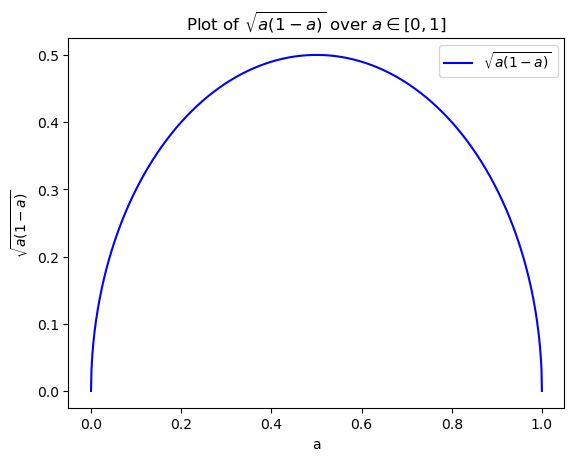

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt

# Define the range for the variable a
a = np.linspace(0, 1, 1000)  # a ranges from 0 to 1 with 1000 points

# Define the function sqrt(a(1-a))
y = np.sqrt(a * (1 - a))

# Plot the function
plt.plot(a, y, label=r'$\sqrt{a(1-a)}$', color='b')

# Add labels and title
plt.xlabel('a')
plt.ylabel(r'$\sqrt{a(1-a)}$')
plt.title(r'Plot of $\sqrt{a(1-a)}$ over $a \in [0, 1]$')
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()

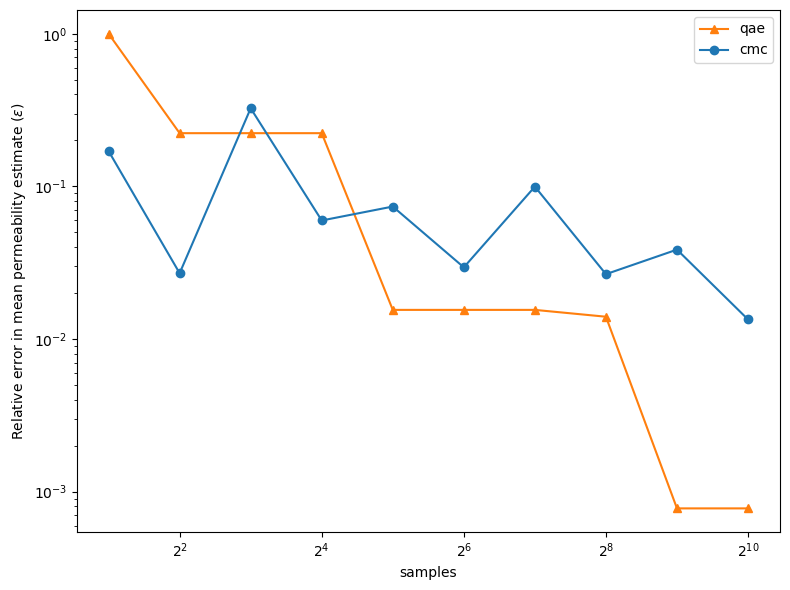

In [25]:
# plot relative error vs number of samples qae vs cmc / fracture flow distribution

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(qae_sample_scaling_list, qae_sample_relative_error_list, color='tab:orange', marker='^', linestyle='-', label='qae')
plt.plot(cmc_sample_scaling_list, cmc_sample_relative_error_list, color='tab:blue', marker='o', linestyle='-', label='cmc')
plt.xlabel('samples')
plt.ylabel(r'Relative error in mean permeability estimate ($\epsilon$)')
# plt.ylabel(r'relative error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.09814 32.44211 / 0.49522 0.04722]')
# plt.title('relative error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_relative_error_vs_samples_fracture_flow.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

In [8]:
%%time
digits_precision_circuit_MAX   = 10   # base 2 precision = ceil(log2(10**digits_precision_base_10))
digits_precision_circuit_FIXED = 6    # fixed size state psi
digits_precision_OUT           = 8    # base 10 precision output

# Iterate over circuit digits of precision
bin_list = []
neq_list = []
qae_problem_tbl_list = []
qae_ae_tbl_list = []
qae_dist_mean_tbl_list = []
qae_sample_mean_tbl_list = []
qae_sample_error_tbl_list = []
# qae_sample_relative_error_tbl_list = []
qae_sample_scaling_tbl_list = []
for digits_precision_circuit in range(2, digits_precision_circuit_FIXED+1, 2):

    dpc = digits_precision_circuit

    ss = int(math.log2(len(ff_samples)))

    index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized = psi_basis_state_sample_index_counts(digits_precision_circuit=dpc, scaling_samples=ss)

    qc = psi_generate_qc(index_circuit_unique_counts, digits_precision_circuit=dpc, scaling_samples=ss)

    problem = EstimationProblem(
        state_preparation=qc,  # A operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    neq = digits_precision_circuit_MAX
        
    sampler = Sampler()
    ae = AmplitudeEstimation(
        num_eval_qubits=neq,  # the number of evaluation qubits specifies circuit width and accuracy
        sampler=sampler,
    )

    ae_result = ae.estimate(problem)
    
    est_qoi_normalized = ae_result.estimation
    num_queries = ae_result.num_oracle_queries
    
    dist_mean_normalized_out = float(np.round(dist_mean_normalized, digits_precision_OUT))
    sample_mean_out = float(np.round(est_qoi_normalized, digits_precision_OUT))
    sample_error_out = float(np.round(sample_error(est_qoi_normalized, dist_mean_normalized), digits_precision_OUT))
    # sample_relative_error_out = float(np.round(sample_relative_error(est_qoi_normalized, dist_mean_normalized), digits_precision_OUT))

    bin_list.append(dpc)
    neq_list.append(neq)
    qae_problem_tbl_list.append(problem)
    qae_ae_tbl_list.append(ae)
    qae_dist_mean_tbl_list.append(dist_mean_normalized_out)
    qae_sample_mean_tbl_list.append(sample_mean_out)
    qae_sample_error_tbl_list.append(sample_error_out)
    # qae_sample_relative_error_tbl_list.append(sample_relative_error_out)
    qae_sample_scaling_tbl_list.append(num_queries+1) # total applications of A


print(bin_list)
print(neq_list)
print(qae_dist_mean_tbl_list)
print(qae_sample_mean_tbl_list)
print(qae_sample_error_tbl_list)
# print(qae_sample_relative_error_tbl_list)
print(qae_sample_scaling_tbl_list)

print()


# problem = problem_list[0]
# ae = ae_list[0]

# ae_circuit = ae.construct_circuit(problem)
# ae_circuit.decompose().draw(
#     "mpl", style="clifford"
# )  # decompose 1 level: exposes the Phase estimation circuit!


# print(dist_mean, dist_sample_mean, dist_mean_normalized, dist_sample_mean_normalized)



2097152
0.4087976294082086 0.40879762940820813 0.4087976294082086 0.40879762940820813

8
0.4001903533935547

2097152
0.4087976294082086 0.40879762940820835 0.4087976294082086 0.40879762940820835

32
0.4086284637451172

2097152
0.4087976294082086 0.4087976294082084 0.4087976294082086 0.4087976294082084

128
0.4087993651628494

[2, 4, 6]
[10, 10, 10]
[0.40879763, 0.40879763, 0.40879763]
[0.3994477, 0.4084801, 0.4084801]
[0.00934993, 0.00031753, 0.00031753]
[1024, 1024, 1024]

CPU times: user 2h 14min 32s, sys: 29min 23s, total: 2h 43min 56s
Wall time: 1h 23min 3s


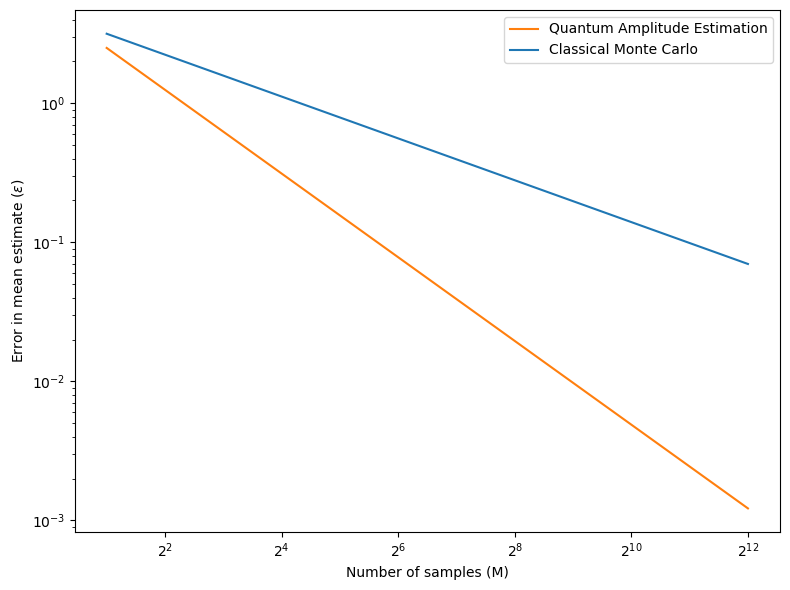

In [38]:
# plot theoretical error vs number of samples qae vs cmc (alpha = 0.05 / 95% CI)

x_ss = np.linspace(2**1, 2**12, 100)                # number of samples
y_ae_error_vs_ss =          5   * x_ss**(-1.0)
y_mc_error_vs_ss =  np.sqrt(20) * x_ss**(-0.5)

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(x_ss, y_ae_error_vs_ss, color='tab:orange', linestyle='-', label='Quantum Amplitude Estimation') # -- -. : / alpha=0.5
plt.plot(x_ss, y_mc_error_vs_ss, color='tab:blue', linestyle='-', label='Classical Monte Carlo')
plt.xlabel('Number of samples (M)')
plt.ylabel(r'Error in mean estimate ($\epsilon$)')
# plt.title('error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
# plt.grid(linestyle='--')
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_error_vs_samples_theoretical.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

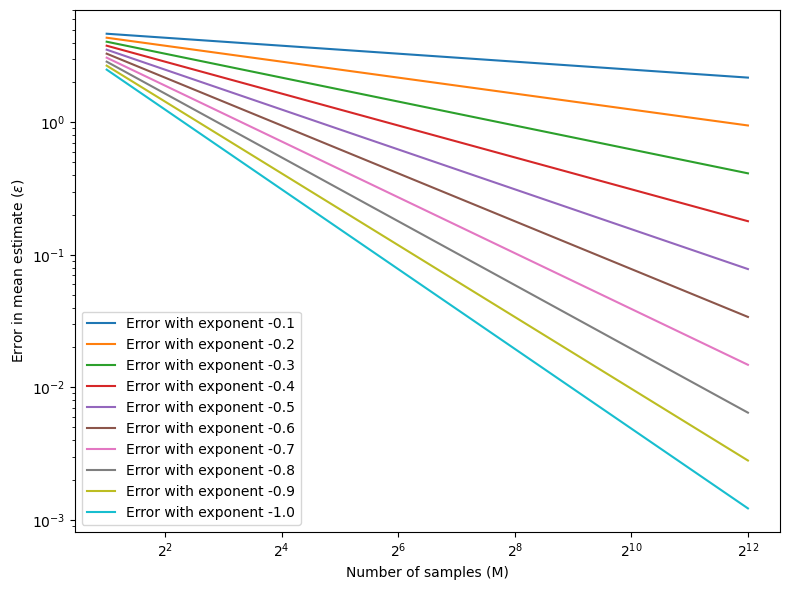

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
x_ss = np.linspace(2**1, 2**12, 100)

# Define the list of powers for the curves
powers = np.arange(-0.1, -1.1, -0.1)

# Plotting the error for each curve
plt.figure(figsize=(8, 6))

# Loop through each power and plot the corresponding curve
for power in powers:
    y_error_vs_ss = 5 * x_ss**power
    plt.plot(x_ss, y_error_vs_ss, label=f'Error with exponent {power:.1f}')

# Labels and scales
plt.xlabel('Number of samples (M)')
plt.ylabel(r'Error in mean estimate ($\epsilon$)')
plt.xscale('log', base=2)
plt.yscale('log')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [9]:
# 
n = 3
y_measured = list(range(0,2**n))
theta_est_nwrt_pi = [(value)*2**(-n) for value in y_measured]
# theta_est_nwrt_pi = [(value+0.5)*2**(-n) for value in y_measured]
out_est_a = [np.round(math.sin(value*math.pi)**2,5) for value in theta_est_nwrt_pi]

print(y_measured)
print(theta_est_nwrt_pi)
print(out_est_a)

[0, 1, 2, 3, 4, 5, 6, 7]
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
[0.0, 0.14645, 0.5, 0.85355, 1.0, 0.85355, 0.5, 0.14645]


In [13]:
theta_nwrt_pi = np.arcsin(math.sqrt(0.49781)) / math.pi
out_a = np.sin(theta_nwrt_pi*math.pi)**2

print(theta_nwrt_pi, out_a)

0.24930289912033501 0.49781


In [10]:
theta_nwrt_pi = np.arcsin(math.sqrt(0.40916)) / math.pi
out_a = np.sin(theta_nwrt_pi*math.pi)**2

print(theta_nwrt_pi, out_a)

0.22092324898335547 0.4091600000000001


In [77]:
dpc = 12
ss = 2**21
index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized = psi_basis_state_sample_index_counts(digits_precision_circuit=dpc, scaling_samples=21)
# print(index_circuit_unique_counts)
print(len(index_circuit_unique_counts))
print(ss)

2097152
0.4087976294082086 0.4087976294082081 0.4087976294082086 0.4087976294082081

4083
2097152


In [78]:
test_ff = np.concatenate([np.full(j,i) for i, j in index_circuit_unique_counts])
test_ff = test_ff * 2**(-dpc)
print(test_ff,len(test_ff),type(test_ff))
print(np.mean(test_ff),np.var(test_ff))

[0.39404297 0.39404297 0.39404297 ... 0.99804688 0.99804688 0.99804688] 2097152 <class 'numpy.ndarray'>
0.40879750112071633 0.057859565167133


In [79]:
val_uc = np.array([i for i, j in index_circuit_unique_counts])
cnt_uc = np.array([j for i, j in index_circuit_unique_counts])
rvw = max(cnt_uc) - cnt_uc
c_scale = ss / sum(rvw)
cnt_rvw_uc = np.round(c_scale * rvw).astype(int)

if sum(cnt_rvw_uc) >= ss:
    N = sum(cnt_rvw_uc) - ss
    res = sorted(range(len(cnt_rvw_uc)), key = lambda sub: cnt_rvw_uc[sub])[-N:]
    cnt_rvw_uc[res]-=1
else:
    N = ss - sum(cnt_rvw_uc)
    res = sorted(range(len(cnt_rvw_uc)), key = lambda sub: cnt_rvw_uc[sub])[-N:]
    cnt_rvw_uc[res]+=1

index_rvw_circuit_unique_counts = zip(val_uc, cnt_rvw_uc)
test_rvw_ff = np.concatenate([np.full(j,i) for i, j in index_rvw_circuit_unique_counts])
test_rvw_ff = test_rvw_ff * 2**(-dpc)

print(N)
# print(N, res, type(res))
# print(cnt_rvw_uc, sum(cnt_rvw_uc), c_scale)
# print(test_rvw_ff, len(test_rvw_ff))
print(np.mean(test_rvw_ff),np.var(test_rvw_ff))

156
0.5947473584674299 0.09059008680804183


In [80]:
min_val_gt = np.min(test_ff)
max_val_gt = np.max(test_ff)
dif_max_min_val_gt = max_val_gt - min_val_gt
test_ff = (test_ff - min_val_gt) / dif_max_min_val_gt

test_ff_mean = np.mean(test_ff)
test_ff_var  = np.var(test_ff)
print(np.round(test_ff_mean,8), np.round(test_ff_var,8))

0.40889733 0.05788783


In [81]:
min_val_gt = np.min(test_rvw_ff)
max_val_gt = np.max(test_rvw_ff)
dif_max_min_val_gt = max_val_gt - min_val_gt
test_rvw_ff = (test_rvw_ff - min_val_gt) / dif_max_min_val_gt

test_rvw_ff_mean = np.mean(test_rvw_ff)
test_rvw_ff_var  = np.var(test_rvw_ff)
print(np.round(test_rvw_ff_mean,8), np.round(test_rvw_ff_var,8))

0.5948926 0.09063434
